In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

class ConvVAE(nn.Module):
    def __init__(self, latent_dims=32):
        super().__init__()

        # ENCODER: 28x28 → 14x14 → 7x7 → 3x3 = 1152 ✓
        self.enc1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)      # 28→14
        self.enc2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)     # 14→7
        self.enc3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)    # 7→3 ✓

        # FIXED: 128 * 3 * 3 = 1152 ✓
        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dims)
        self.fc_logvar = nn.Linear(128 * 3 * 3, latent_dims)

        # DECODER: Perfect reverse
        self.fc1 = nn.Linear(latent_dims, 128 * 3 * 3)
        self.dec1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, output_padding=1)  # 3→7
        self.dec2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)                    # 7→14
        self.dec3 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)                     # 14→28 ✓

    def encode(self, x):
        h = F.relu(self.enc1(x))
        h = F.relu(self.enc2(h))
        h = F.relu(self.enc3(h))
        h = torch.flatten(h, start_dim=1)  # [B, 1152] ✓
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc1(z)).view(-1, 128, 3, 3)  # 3x3 ✓
        h = F.relu(self.dec1(h))
        h = F.relu(self.dec2(h))
        return torch.sigmoid(self.dec3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Data + Training (unchanged)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

model = ConvVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset):.4f}')


100%|██████████| 9.91M/9.91M [00:00<00:00, 19.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 517kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.4MB/s]


Epoch 1, Loss: 176.4917
Epoch 2, Loss: 114.7572
Epoch 3, Loss: 107.9645
Epoch 4, Loss: 105.1992
Epoch 5, Loss: 103.5672
Epoch 6, Loss: 102.3988
Epoch 7, Loss: 101.5545
Epoch 8, Loss: 100.8893
Epoch 9, Loss: 100.3523
Epoch 10, Loss: 99.8121


Original: digit 7


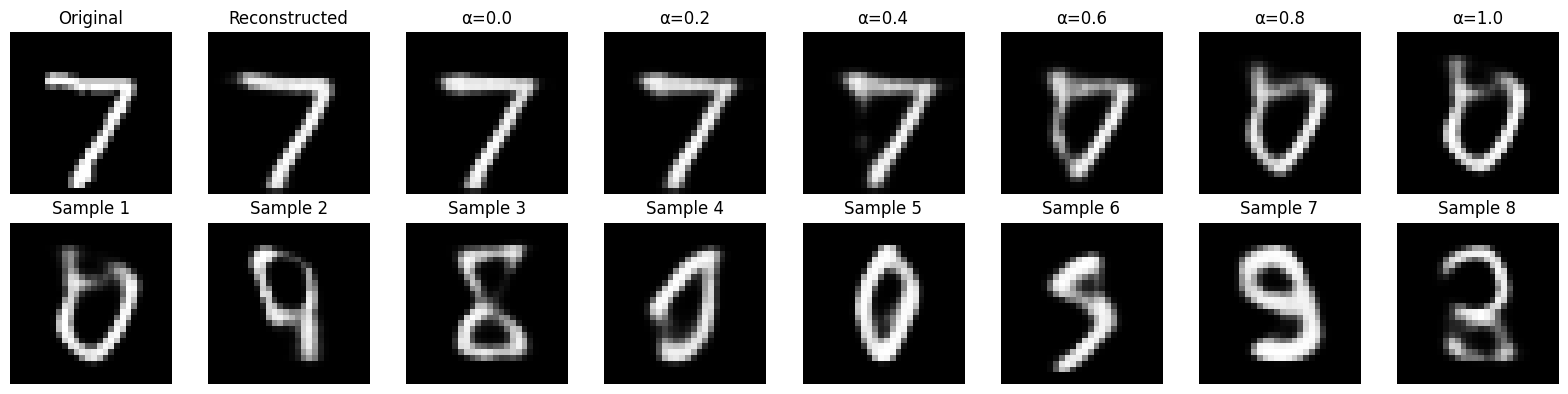

In [ ]:
import matplotlib.pyplot as plt
def inference_demo(model, sample_image=None):
    model.eval()

    with torch.no_grad():
        if sample_image is None:
            test_dataset = torchvision.datasets.MNIST('data', train=False, download=True,
                                                    transform=transforms.ToTensor())
            x, label = test_dataset[0]
            x = x.unsqueeze(0).to(device)
        else:
            x = sample_image.unsqueeze(0).to(device)

        # Encode
        mu, logvar = model.encode(x)
        z = model.reparameterize(mu, logvar)
        print(f"Original: digit {label if 'label' in locals() else '?'}")

        # Reconstruct
        recon_x = model.decode(mu)

        # Generate new samples
        z_new = torch.randn(8, 32).to(device)
        samples = model.decode(z_new)

        # FIXED: 2x8 grid (16 total subplots)
        fig, axes = plt.subplots(2, 8, figsize=(16, 4))

        # Original + Reconstruction
        axes[0,0].imshow(x[0,0].cpu(), cmap='gray')
        axes[0,0].set_title('Original')
        axes[0,0].axis('off')

        axes[0,1].imshow(recon_x[0,0].cpu().detach(), cmap='gray')
        axes[0,1].set_title('Reconstructed')
        axes[0,1].axis('off')

        # Latent interpolation (6 steps instead of 8)
        for i in range(6):
            alpha = i / 5.0
            z_interp = (1-alpha) * z + alpha * z_new[0:1]
            interp_img = model.decode(z_interp)[0,0].cpu()
            axes[0,2+i].imshow(interp_img.detach(), cmap='gray')
            axes[0,2+i].set_title(f'α={alpha:.1f}')
            axes[0,2+i].axis('off')

        # Fill remaining with generated samples
        for i in range(6, 8):
            axes[0,i].axis('off')
        for i in range(8):
            axes[1,i].imshow(samples[i,0].cpu().detach(), cmap='gray')
            axes[1,i].set_title(f'Sample {i+1}')
            axes[1,i].axis('off')

        plt.tight_layout()
        plt.show()

        return mu, recon_x, samples
mu, recon, samples = inference_demo(model)

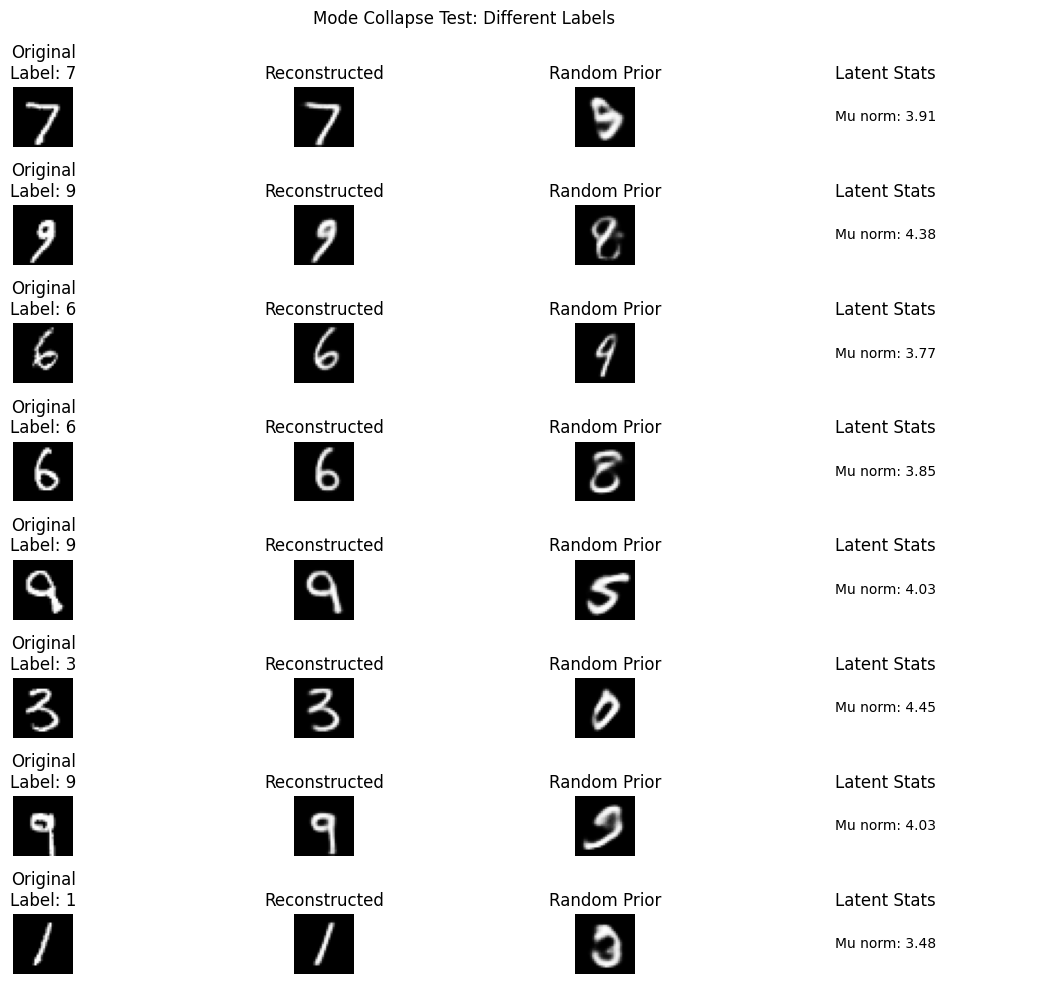

In [ ]:
def test_multiple_labels(model, num_samples=5):
    """Test reconstruction across different digits to detect mode collapse"""
    model.eval()
    test_dataset = torchvision.datasets.MNIST('data', train=False, download=True,
                                            transform=transforms.ToTensor())

    fig, axes = plt.subplots(num_samples, 4, figsize=(12, num_samples*1.2))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        for i in range(num_samples):
            # Pick different labels
            idx = i * 1000  # Spread out samples
            x, label = test_dataset[idx]
            x = x.unsqueeze(0).to(device)

            # Encode → Decode
            mu, logvar = model.encode(x)
            recon_x = model.decode(mu)

            # Plot
            axes[i,0].imshow(x[0,0].cpu(), cmap='gray')
            axes[i,0].set_title(f'Original\nLabel: {label}')
            axes[i,1].imshow(recon_x[0,0].cpu(), cmap='gray')
            axes[i,1].set_title('Reconstructed')

            # Generate from PRIOR (tests mode coverage)
            z_prior = torch.randn(1, 32).to(device)
            prior_sample = model.decode(z_prior)
            axes[i,2].imshow(prior_sample[0,0].cpu(), cmap='gray')
            axes[i,2].set_title('Random Prior')

            axes[i,3].text(0.5, 0.5, f'Mu norm: {torch.norm(mu).item():.2f}',
                          ha='center', va='center', transform=axes[i,3].transAxes)
            axes[i,3].set_title('Latent Stats')
            axes[i,3].axis('off')

            for ax in axes[i]:
                ax.axis('off')

    plt.tight_layout()
    plt.suptitle('Mode Collapse Test: Different Labels', y=1.02)
    plt.show()

# Run test
test_multiple_labels(model, num_samples=8)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.ReLU(True),
            nn.Linear(256, 512), nn.ReLU(True),
            nn.Linear(512, 784), nn.Tanh()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x.view(-1, 784)).squeeze()  # FIXED: [128,1] → [128]

# Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

# Models
G = Generator(100).to(device)
D = Discriminator().to(device)
optimizerG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

print("Training GAN...")
for epoch in range(20):
    for i, (real_imgs, _) in enumerate(dataloader):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        # Train Discriminator
        optimizerD.zero_grad()
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        real_output = D(real_imgs)
        d_loss_real = criterion(real_output, real_labels)

        noise = torch.randn(batch_size, 100, device=device)
        fake_imgs = G(noise)
        fake_output = D(fake_imgs.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizerD.step()

        # Train Generator
        optimizerG.zero_grad()
        fake_output = D(fake_imgs)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizerG.step()

    # if epoch % 10 == 0:
    print(f'Epoch {epoch}, D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}')

Training GAN...
Epoch 0, D_loss: 0.3939, G_loss: 3.1746
Epoch 1, D_loss: 0.5192, G_loss: 3.0373
Epoch 2, D_loss: 2.8944, G_loss: 3.4161
Epoch 3, D_loss: 0.1402, G_loss: 4.6529
Epoch 4, D_loss: 0.2977, G_loss: 4.0225
Epoch 5, D_loss: 0.1334, G_loss: 4.7838
Epoch 6, D_loss: 0.4713, G_loss: 8.7902
Epoch 7, D_loss: 0.1862, G_loss: 3.2346
Epoch 8, D_loss: 0.1422, G_loss: 3.6194
Epoch 9, D_loss: 0.1919, G_loss: 2.4509
Epoch 10, D_loss: 0.9543, G_loss: 1.3812
Epoch 11, D_loss: 1.3824, G_loss: 5.0227
Epoch 12, D_loss: 0.3920, G_loss: 5.2628
Epoch 13, D_loss: 0.5343, G_loss: 2.2543
Epoch 14, D_loss: 0.3662, G_loss: 3.3494
Epoch 15, D_loss: 0.6159, G_loss: 1.6917
Epoch 16, D_loss: 0.6933, G_loss: 1.7773
Epoch 17, D_loss: 0.5971, G_loss: 1.8131
Epoch 18, D_loss: 1.0913, G_loss: 4.1633
Epoch 19, D_loss: 0.8676, G_loss: 1.2348


GAN Diversity Metrics:
Unique clusters: 10/10
Largest cluster: 11/64 (17.2%)
Silhouette score: 0.177


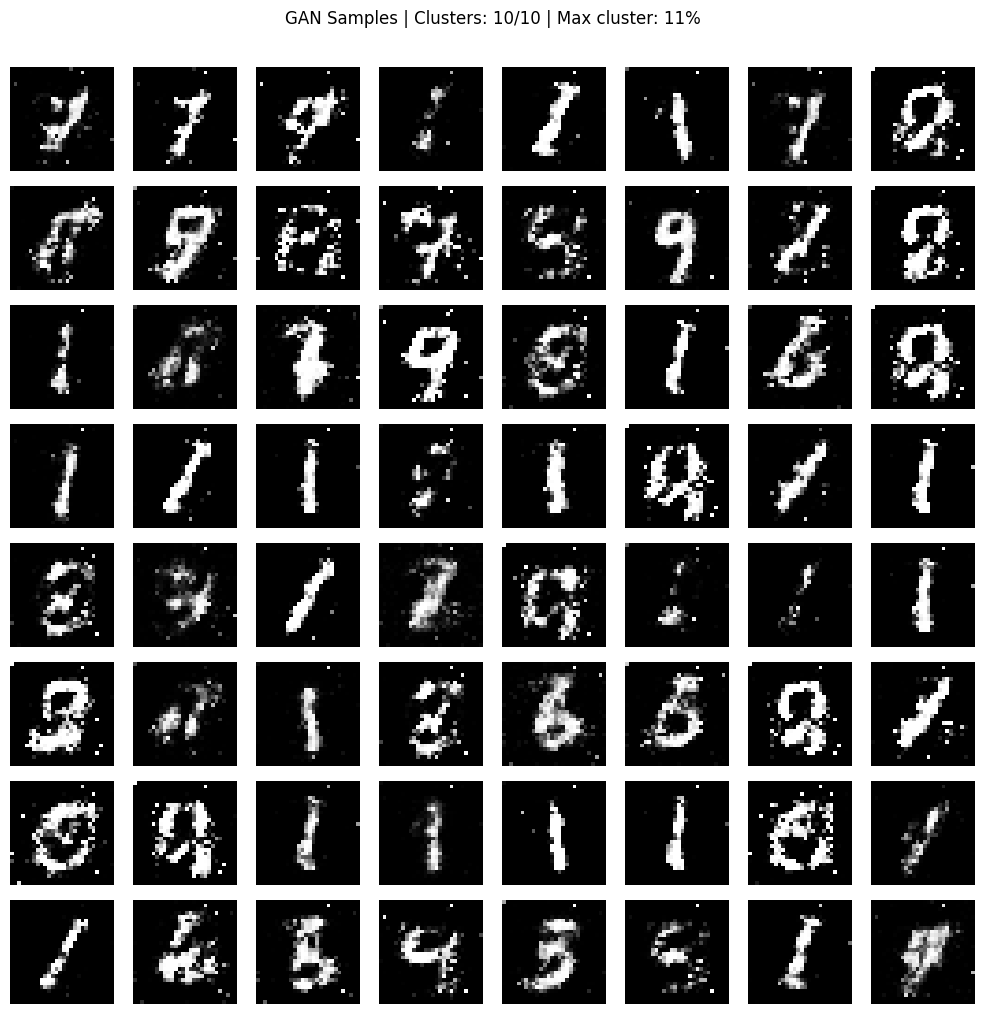

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def gan_mode_collapse_test(G, num_samples=8, fixed_seed=None):
    """Test GAN for mode collapse - generate 64 samples, check diversity"""
    G.eval()

    # Generate 64 samples
    with torch.no_grad():
        if fixed_seed:
            torch.manual_seed(fixed_seed)
        noise = torch.randn(64, 100).to(device)
        samples = 0.5 * G(noise).cpu() + 0.5  # Denormalize [0,1]

    # Calculate diversity metrics
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score

    # Flatten samples for clustering
    sample_flat = samples.view(64, -1).numpy()

    # 1. Cluster into 10 groups (MNIST digits)
    kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
    labels = kmeans.fit_predict(sample_flat)

    # 2. Diversity metrics
    unique_digits = len(np.unique(labels))
    max_cluster_size = max(np.bincount(labels))
    silhouette = silhouette_score(sample_flat, labels)

    print(f"GAN Diversity Metrics:")
    print(f"Unique clusters: {unique_digits}/10")
    print(f"Largest cluster: {max_cluster_size}/64 ({max_cluster_size/64*100:.1f}%)")
    print(f"Silhouette score: {silhouette:.3f}")

    # Visualize 8x8 grid
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i, 0], cmap='gray')
        ax.axis('off')

    plt.suptitle(f'GAN Samples | Clusters: {unique_digits}/10 | Max cluster: {max_cluster_size}%', y=1.01)
    plt.tight_layout()
    plt.show()
    return unique_digits, max_cluster_size

# Run after GAN training
unique, max_size = gan_mode_collapse_test(G)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
from torch.nn import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Diffusion Scheduler
class DiffusionScheduler:
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x, t, noise):
        """Forward diffusion: x_t = sqrt(alpha_bar) * x_0 + sqrt(1-alpha_bar) * noise"""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bars[t]).view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bars[t]).view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

    def get_initial_noise(self, batch_size):
        return torch.randn(batch_size, 1, 28, 28).to(device)

# Simple U-Net for MNIST
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, 64), nn.SiLU(),
            nn.Linear(64, 64)
        )

        # Encoder (save for skips)
        self.down1 = nn.Sequential(  # Skip 1: 64ch, 28x28
            nn.Conv2d(1, 64, 3, padding=1), nn.SiLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.SiLU()
        )
        self.down2 = nn.Sequential(  # Skip 2: 128ch, 14x14
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.SiLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.SiLU()
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1), nn.SiLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.SiLU()
        )

        # Decoder WITH SKIPS
        self.up2 = nn.Sequential(  # 14x14 → 28x28
            nn.ConvTranspose2d(128+128, 64, 4, stride=2, padding=1), nn.SiLU(),  # 256→64
            nn.Conv2d(64, 64, 3, padding=1), nn.SiLU()
        )
        self.final = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_mlp(t.unsqueeze(-1)).view(-1, 64, 1, 1)

        # ENCODER (save skips)
        skip1 = self.down1(x)      # [B, 64, 28, 28]
        skip2 = self.down2(skip1)  # [B, 128, 14, 14]

        # Bottleneck
        x = self.bottleneck(skip2)  # [B, 128, 14, 14]

        # DECODER WITH SKIPS ✅
        x = self.up2(torch.cat([x, skip2], dim=1))  # 128+128=256 → 64ch, 28x28
        x = x + skip1  # Skip connection 64+64 → 64ch, 28x28 ✅

        return self.final(x + t_emb[:, :1])


# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

# Models
scheduler = DiffusionScheduler()
model = SimpleUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

# Training
print("Training Diffusion Model...")
for epoch in range(20):  # Fast training for MNIST
    total_loss = 0
    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(device)
        batch_size = images.size(0)

        # Random timesteps
        t = torch.randint(0, scheduler.num_timesteps, (batch_size,), device=device).float()

        # Forward diffusion
        noise = torch.randn_like(images).to(device)
        x_noisy = scheduler.add_noise(images, t.long(), noise)

        # Predict noise
        optimizer.zero_grad()
        predicted_noise = model(x_noisy, t / scheduler.num_timesteps)
        loss = F.mse_loss(predicted_noise, noise)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f'Epoch {epoch}, Avg Loss: {total_loss/len(dataloader):.4f}')

# Sampling
def sample(model, scheduler, num_samples=64):
    model.eval()
    x = scheduler.get_initial_noise(num_samples)

    for i in reversed(range(scheduler.num_timesteps)):
        t = torch.full((num_samples,), i, device=device).float()
        t_rel = t / scheduler.num_timesteps

        with torch.no_grad():
            noise_pred = model(x, t_rel)

            # Reverse step (simplified DDPM)
            alpha = scheduler.alphas[i]
            alpha_bar = scheduler.alpha_bars[i]
            beta = scheduler.betas[i]

            if i > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0

            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * noise_pred) + torch.sqrt(beta) * noise

    x = 0.5 * x.cpu() + 0.5  # Denormalize
    return x




Training Diffusion Model...
Epoch 0, Avg Loss: 0.1693
Epoch 1, Avg Loss: 0.0668
Epoch 2, Avg Loss: 0.0538
Epoch 3, Avg Loss: 0.0492
Epoch 4, Avg Loss: 0.0519
Epoch 5, Avg Loss: 0.0451
Epoch 6, Avg Loss: 0.0417
Epoch 7, Avg Loss: 0.0394
Epoch 8, Avg Loss: 0.0385
Epoch 9, Avg Loss: 0.0371
Epoch 10, Avg Loss: 0.0358
Epoch 11, Avg Loss: 0.0356
Epoch 12, Avg Loss: 0.0340
Epoch 13, Avg Loss: 0.0339
Epoch 14, Avg Loss: 0.0333
Epoch 15, Avg Loss: 0.0327
Epoch 16, Avg Loss: 0.0323
Epoch 17, Avg Loss: 0.0317
Epoch 18, Avg Loss: 0.0319
Epoch 19, Avg Loss: 0.0317


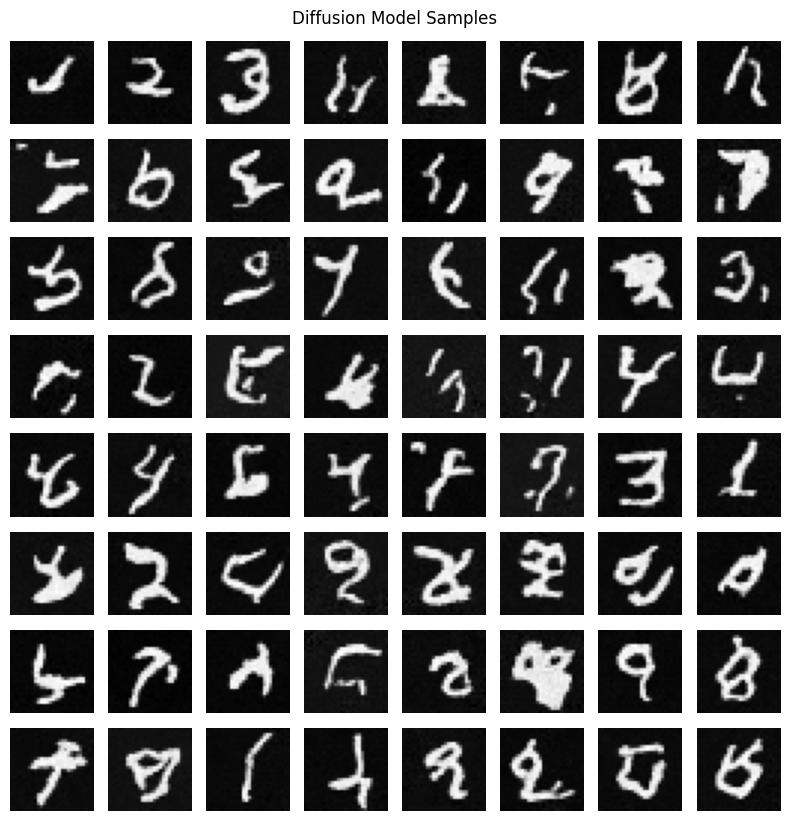

In [ ]:
# Generate samples
samples = sample(model, scheduler)
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i, 0], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.suptitle('Diffusion Model Samples', y=1.02)
plt.show()